## DL Ops Assignment 4
### Question 2
#### Submitted by - Debonil Ghosh [ M21AIE225 ]

In [1]:
!pip install optuna

In [2]:
# %%
import pandas as pd
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from sklearn import metrics
import seaborn as sns
import time
import math
import numpy as np
import matplotlib.pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Available device ==> {device}')


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


# %%
!rm -rf ./logs
# Train the model
def model_training(model, criterion, optimizer, trainloader, testloader, num_epochs=10, model_name='model'):
    start = time.time()
    loss_list = []
    model.train()
    with torch.profiler.profile(
            schedule=torch.profiler.schedule(
                wait=1, warmup=1, active=10, repeat=5),
            on_trace_ready=torch.profiler.tensorboard_trace_handler(
                './logs/'+model_name),
            record_shapes=True,
            profile_memory=True,
            with_stack=True
    ) as prof:
        for epoch in range(num_epochs):
            epoch_start = time.time()
            train_loss = 0.0
            val_loss = 0.0
            train_acc = 0.0
            val_acc = 0.0
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += metrics.accuracy_score(labels.cpu().detach(
                ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
                prof.step()
            # Evaluate the model on the validation set
            with torch.no_grad():
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    val_acc += metrics.accuracy_score(labels.cpu().detach(
                    ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
            train_loss = train_loss/len(trainloader)
            val_loss = val_loss/len(testloader)
            train_acc = train_acc/len(trainloader)
            val_acc = val_acc/len(testloader)
            print(f'Epoch: {epoch+1} ({timeSince(epoch_start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ')
            loss_list.append([train_loss, val_loss, train_acc, val_acc])

        print(
            f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
        return np.array(loss_list), time.time()-start, loss_list[-1][2], loss_list[-1][3]


# %%
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred, classes, title=''):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    f1_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

    plt.figure(figsize=(10, 10))
    plt.title(
        f'{title} : Accuracy : {overallAccuracy*100:3.2f}% | F1 Score : {f1_score*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',
                fmt='g', xticklabels=classes, yticklabels=classes)

    plt.show()
    plt.savefig(
        f'confusion_mat_{title}_{time.time()}.png', bbox_inches='tight')
    print(f'Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'F1 Score: {f1_score*100:3.3f}%')
    classwiseAccuracy_df = pd.DataFrame(
        data=[classwiseAccuracy], columns=classes)
    print(
        f'\nClasswise Accuracy Score: \n{classwiseAccuracy_df.to_markdown(index=False)}')
    print('\nConfusion Matrix:')
    print(cm.to_markdown())


# %%
def plot_training_graphs(loss_list, title=''):
    fig = plt.figure(figsize=(20, 7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title(f"{title} : Training vs Validation loss")
    plot.plot(loss_list[:, 0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:, 1], linestyle='-', label="Validation Loss")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title(f"{title} : Training vs Validation Accuracy")
    plot.plot(loss_list[:, 2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:, 3], linestyle='-', label="Validation Accuracy")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()
    plt.savefig(
        f'training_loss_{title}_{time.time()}.png', bbox_inches='tight')


Available device ==> cpu


'rm' is not recognized as an internal or external command,
operable program or batch file.


 Load and preprocessing CIFAR10 dataset using standard augmentation and normalization techniques [10 Marks]

In [4]:
# Load and preprocessing CIFAR10 dataset using standard augmentation and
# normalization techniques [10 Marks]
# %%
data_path = '../.data'
transform = T.Compose(
    [T.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(
    root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True)
test_set = torchvision.datasets.FashionMNIST(
    root=data_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)


100%|██████████| 26421880/26421880 [00:05<00:00, 5115649.38it/s]


Extracting ../.data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../.data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 132085.21it/s]


Extracting ../.data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../.data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2565383.08it/s]


Extracting ../.data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../.data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ../.data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../.data\FashionMNIST\raw



○ VGG16

In [5]:
import torchvision.models
vgg16_model = torchvision.models.vgg16(
    weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1).to(device)
print(vgg16_model.train())


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def train_vgg16_model():
    model_name = 'vgg16_model'
    optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list, t, train_a, test_a = model_training(
        vgg16_model, criterion, optimizer, trainloader, testloader, num_epochs=10, model_name=model_name)
    plot_training_graphs(loss_list, title=model_name)
    vgg16_model.eval()
    with torch.no_grad():
        test_labels = []
        test_output = []
        for batch in testloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = vgg16_model(x)
            test_labels += y.cpu()
            test_output += torch.argmax(y_hat, dim=1).cpu()

        test_labels = np.array(test_labels)
        test_output = np.array(test_output)
        print(f'\nModel Evaluation Summary:')
        confusionMatrixAndAccuracyReport(
            test_labels, test_output, test_set.classes, title=model_name)


Epoch: 1 (2m 21s) 	Training Loss: 0.807, 	Test Loss: 0.505,  	Training acc: 0.74, 	Test acc: 0.83, 
Epoch: 2 (2m 2s) 	Training Loss: 0.406, 	Test Loss: 0.464,  	Training acc: 0.87, 	Test acc: 0.86, 
Epoch: 3 (2m 2s) 	Training Loss: 0.262, 	Test Loss: 0.440,  	Training acc: 0.91, 	Test acc: 0.86, 
Epoch: 4 (2m 2s) 	Training Loss: 0.183, 	Test Loss: 0.473,  	Training acc: 0.94, 	Test acc: 0.87, 
Epoch: 5 (2m 3s) 	Training Loss: 0.140, 	Test Loss: 0.487,  	Training acc: 0.96, 	Test acc: 0.88, 
Epoch: 6 (2m 3s) 	Training Loss: 0.108, 	Test Loss: 0.602,  	Training acc: 0.97, 	Test acc: 0.86, 
Epoch: 7 (2m 3s) 	Training Loss: 0.091, 	Test Loss: 0.650,  	Training acc: 0.97, 	Test acc: 0.87, 
Epoch: 8 (2m 2s) 	Training Loss: 0.075, 	Test Loss: 0.619,  	Training acc: 0.98, 	Test acc: 0.87, 
Epoch: 9 (2m 2s) 	Training Loss: 0.071, 	Test Loss: 0.566,  	Training acc: 0.98, 	Test acc: 0.87, 
Epoch: 10 (2m 2s) 	Training Loss: 0.061, 	Test Loss: 0.616,  	Training acc: 0.98, 	Test acc: 0.87, 
Training

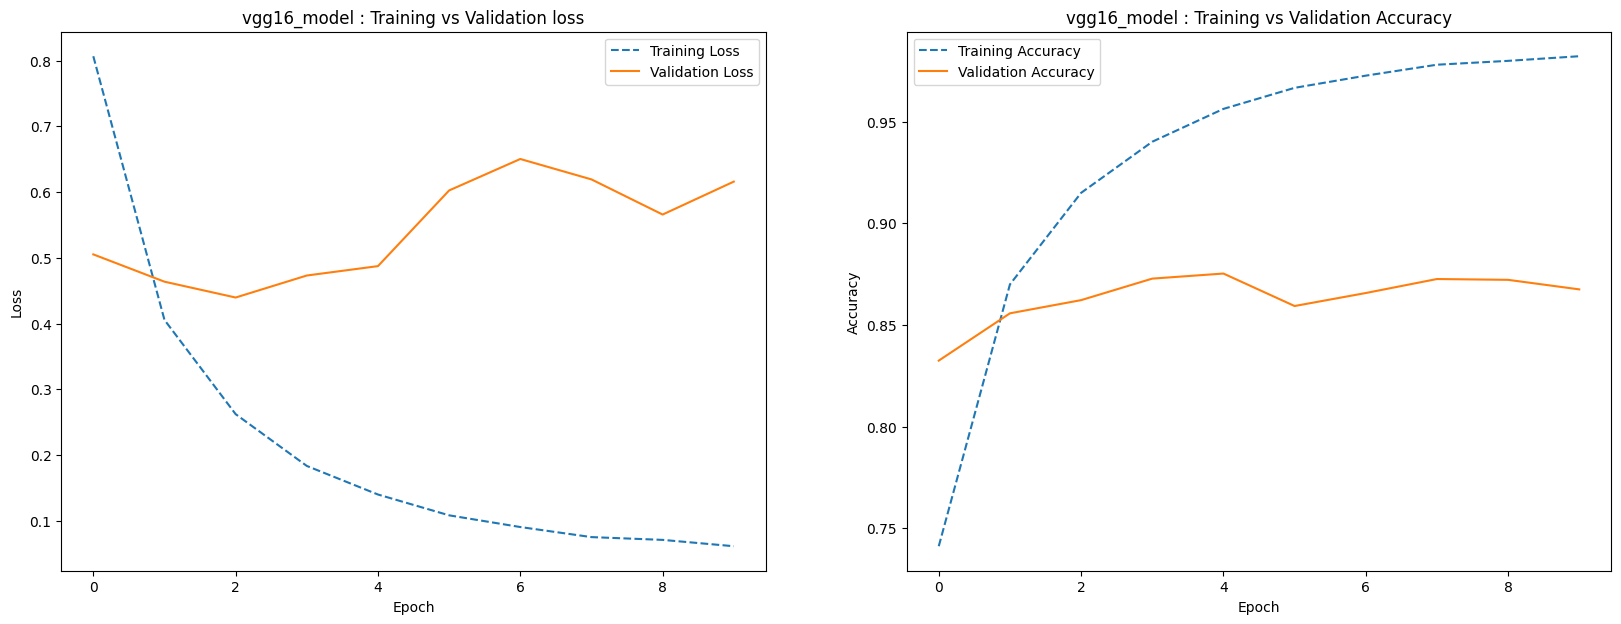


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

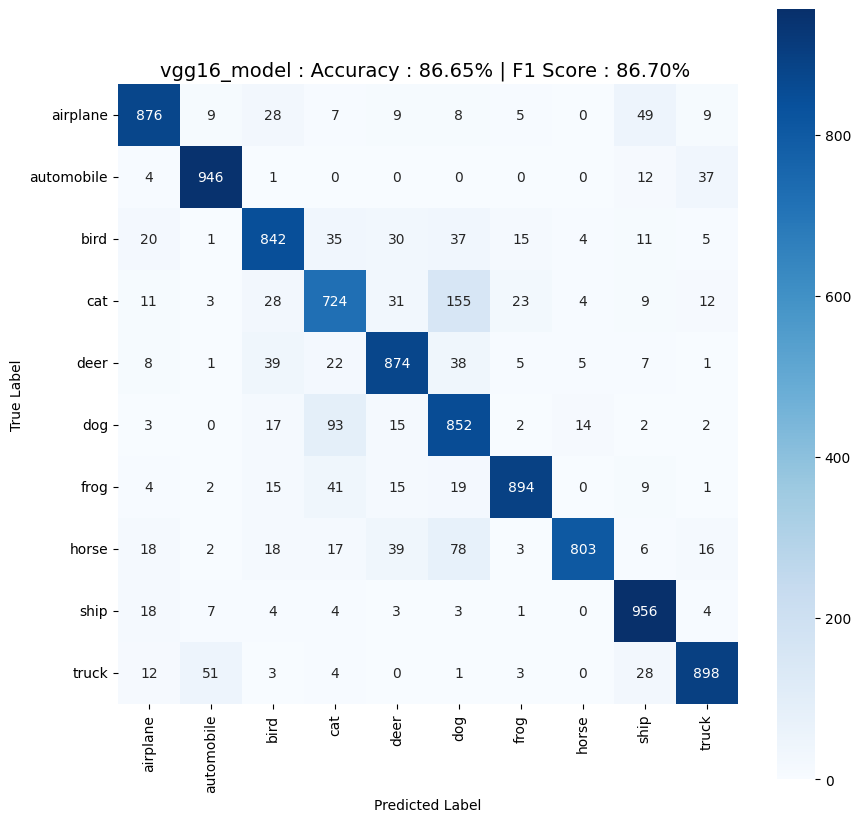

Accuracy: 86.650%
F1 Score: 86.700%

Classwise Accuracy Score: 
|   airplane |   automobile |   bird |   cat |   deer |   dog |   frog |   horse |   ship |   truck |
|-----------:|-------------:|-------:|------:|-------:|------:|-------:|--------:|-------:|--------:|
|      0.876 |        0.946 |  0.842 | 0.724 |  0.874 | 0.852 |  0.894 |   0.803 |  0.956 |   0.898 |

Confusion Matrix:
| True Label   |   airplane |   automobile |   bird |   cat |   deer |   dog |   frog |   horse |   ship |   truck |
|:-------------|-----------:|-------------:|-------:|------:|-------:|------:|-------:|--------:|-------:|--------:|
| airplane     |        876 |            9 |     28 |     7 |      9 |     8 |      5 |       0 |     49 |       9 |
| automobile   |          4 |          946 |      1 |     0 |      0 |     0 |      0 |       0 |     12 |      37 |
| bird         |         20 |            1 |    842 |    35 |     30 |    37 |     15 |       4 |     11 |       5 |
| cat          |         1

<Figure size 640x480 with 0 Axes>

In [37]:
train_vgg16_model()


In [47]:
vgg16_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomImageClassifier(nn.Module):
    def __init__(self):
        super(CustomImageClassifier, self).__init__()
        # batch_size = 32
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=256*4*4, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 256*4*4)
        x = self.fc_layers(x)
        return x


custom_cnn_model = CustomImageClassifier().to(device)
print(custom_cnn_model.train())


In [ ]:
def train_custom_cnn_model(trial):
    model_name = 'custom_cnn_model'
    lr = trial.suggest_float("lr", 1e-6, 1e-1, log=True)
    optimizer = torch.optim.Adam(custom_cnn_model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list, t, train_a, test_a = model_training(
        custom_cnn_model, criterion, optimizer, trainloader, testloader, num_epochs=10, model_name=model_name)
    plot_training_graphs(loss_list, title=model_name)
    custom_cnn_model.eval()
    with torch.no_grad():
        test_labels = []
        test_output = []
        for batch in testloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = custom_cnn_model(x)
            test_labels += y.cpu()
            test_output += torch.argmax(y_hat, dim=1).cpu()

        test_labels = np.array(test_labels)
        test_output = np.array(test_output)
        print(f'\nModel Evaluation Summary:')
        confusionMatrixAndAccuracyReport(
            test_labels, test_output, test_set.classes, title=model_name)


In [ ]:
import optuna
from optuna.trial import TrialState

study = optuna.create_study(direction="maximize")
study.optimize(train_custom_cnn_model, n_trials=100, timeout=60000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(
    deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
